# CAST
Collocated
Allong
Satellite
Track

### ToDo
- [x] read model data into a xarray dataset
- [x] read ADM data into a xarray dataset
- collocate model to ADM grid
  - [x] lon/lat
  - [x] time (not using right now)
  - [x] altitude/elevation
- example plot
  - [x] point plot for ADM/EMEP, per orbit
  - [x] scatterplot, per orbit
  - [x] curtain plots for ADM/EMEP, per orbit
  - [ ] plots for mean(bias)/RMSE/corr, per orbit

# Conda environment at PPI/lustre

```bash
# load right (ana)conda module
module load aerocom/anaconda3-stable

# use altair for plotting
source activate altair

# start notebook
jupyter lab --no-browser --ip=$HOSTNAME.met.no

```

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import altair as alt
from glob import glob

for m in [np, pd, xr, alt]:
    print(m.__name__, m.__version__)

numpy 1.14.2
pandas 0.23.4
xarray 0.10.8
altair 2.2.2


# Read NetCDF files
list the emep forecast and adm orbit files for a given date

In [2]:
lustre = '/lustre/storeB/project/fou/kl/%s'
archive = dict(
    emepmodel = lustre%'emep/ModelRuns/ADM_Aeolus/EMEPmodel/CWF_12ST-%Y%m%d_hourInst.nc',
    topomodel = lustre%'emep/ModelRuns/ADM_Aeolus/EMEPmodel/MACC14_topo.nc',
    admaeolus = lustre%'admaeolus/data.rev.TD01/netcdf_emep_domain/AE_TD01_ALD_U_N_2A_%Y%m%d*.DBL.nc',
)

date = pd.to_datetime('20181201')
ncfile = dict(
    emepmodel = date.strftime(archive['emepmodel']),
    topomodel = None, # waiting for topo file for MACC14 domain
    admaeolus = glob(date.strftime(archive['admaeolus'])),
)

for k, v in ncfile.items():
    if isinstance(v, str):
        print(k, v)
    elif isinstance(v, list):
        for f in v:
            print(k, f)


emepmodel /lustre/storeB/project/fou/kl/emep/ModelRuns/ADM_Aeolus/EMEPmodel/CWF_12ST-20181201_hourInst.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD01/netcdf_emep_domain/AE_TD01_ALD_U_N_2A_20181201T050538026_005423993_001591_0001.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD01/netcdf_emep_domain/AE_TD01_ALD_U_N_2A_20181201T080602025_005411999_001593_0001.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD01/netcdf_emep_domain/AE_TD01_ALD_U_N_2A_20181201T063550026_005424013_001592_0001.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD01/netcdf_emep_domain/AE_TD01_ALD_U_N_2A_20181201T153538028_005459994_001598_0001.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD01/netcdf_emep_domain/AE_TD01_ALD_U_N_2A_20181201T183838026_008471993_001600_0001.DBL.nc
admaeolus /lustre/storeB/project/fou/kl/admaeolus/data.rev.TD01/netcdf_emep_domain/AE_TD01_ALD_U_N_2A_20181201T140502021_005448000_001597_0001.D

## EMEP forecat
model `Z_MID` + `topography`

In [3]:
emep = xr.open_dataset(ncfile['emepmodel']).rename({"Z_MID":"alt"}).set_coords("alt")
if ncfile['topomodel']:
    topo = xr.open_dataset(ncfile['topomodel']).topography.isel(time=0)
    topo["lon"] = emep.lon
    topo["lat"] = emep.lat
    emep["alt"] += topo
    
# convert units: 1/m to 1/km
emep['EXT_350nm'] *= 1e3 # 1/m to 1e-3/m
emep['EXT_350nm'].attrs['units'] = "1/km"

emep

<xarray.Dataset>
Dimensions:         (ilev: 21, lat: 369, lev: 20, lon: 301, time: 25)
Coordinates:
  * lon             (lon) float64 -30.0 -29.75 -29.5 -29.25 -29.0 -28.75 ...
  * lat             (lat) float64 30.0 30.12 30.25 30.38 30.5 30.62 30.75 ...
  * lev             (lev) float64 0.1167 0.1528 0.1888 0.2271 0.2744 0.3362 ...
  * ilev            (ilev) float64 0.09869 0.1347 0.1708 0.2068 0.2474 ...
  * time            (time) datetime64[ns] 2018-12-01 2018-12-01T01:00:00 ...
    alt             (time, lev, lat, lon) float32 ...
Data variables:
    P0              float64 ...
    hyam            (lev) float64 ...
    hybm            (lev) float64 ...
    hyai            (ilev) float64 ...
    hybi            (ilev) float64 ...
    AOD_350nm       (time, lat, lon) float32 ...
    AOD_DUST_350nm  (time, lat, lon) float32 ...
    AOD_SS_350nm    (time, lat, lon) float32 ...
    AOD_SIA_350nm   (time, lat, lon) float32 ...
    AOD_500nm       (time, lat, lon) float32 ...
    AOD_550n

## ADM observations

In [4]:
adm = xr.open_dataset(ncfile['admaeolus'][0])

# convert units: 1/Mm to 1/km
adm['ec355aer'] *= 1e-3 # 1e-6/m to 1e-3/m
adm['ec355aer'].attrs['units'] = "1/km"

adm

<xarray.Dataset>
Dimensions:    (point: 1176)
Coordinates:
  * point      (point) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
Data variables:
    time       (point) datetime64[ns] ...
    ec355aer   (point) float64 0.0 0.01517 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    bs355aer   (point) float64 ...
    latitude   (point) float64 ...
    longitude  (point) float64 ...
    altitude   (point) float64 ...
Attributes:
    product:              AE_TD01_ALD_U_N_2A_20181201T050538026_005423993_001...
    proc_stage:           N
    ref_doc:              AE-IF-DLR-L2A-004 03.02
    acquisition_station:  Kiruna              
    proc_center:          Esrin 
    proc_time:            598615521.692
    software_ver:         ADM_L2Ap/3.7  
    baseline:              NaN                         
    sensing_start:        596955938.026351
    sensing_stop:         596961362.019943
    phase:                1
    cycle:                14
    rel_orbit:            24
    abs_orbit:          

# CAST

### Collocate lon, lat & time

In [5]:
collocate = lambda model, obs: model.load().sel(
    lon=obs.longitude,
    lat=obs.latitude,
#   alt=obs.altitude,
    time=obs.time,
    method='nearest'
)

%time emep = collocate(emep, adm)

emep.EXT_350nm

CPU times: user 6.42 s, sys: 320 ms, total: 6.74 s
Wall time: 7.42 s


<xarray.DataArray 'EXT_350nm' (point: 1176, lev: 20)>
array([[0.      , 0.000669, 0.000873, ..., 0.01562 , 0.015154, 0.018953],
       [0.      , 0.000669, 0.000873, ..., 0.01562 , 0.015154, 0.018953],
       [0.      , 0.000669, 0.000872, ..., 0.015965, 0.015488, 0.019484],
       ...,
       [0.      , 0.000712, 0.000788, ..., 0.082086, 0.08635 , 0.090742],
       [0.      , 0.000712, 0.000788, ..., 0.082086, 0.08635 , 0.090742],
       [0.      , 0.000712, 0.000788, ..., 0.082086, 0.08635 , 0.090742]],
      dtype=float32)
Coordinates:
    lon      (point) float64 31.0 31.0 30.75 30.75 30.75 30.75 30.75 30.75 ...
    lat      (point) float64 75.38 75.38 75.38 75.38 75.5 75.5 75.5 75.5 ...
  * lev      (lev) float64 0.1167 0.1528 0.1888 0.2271 0.2744 0.3362 0.4114 ...
    time     (point) datetime64[ns] 2018-12-01T05:00:00 2018-12-01T05:00:00 ...
    alt      (point, lev) float32 14396.161 12764.9375 11463.546 10322.826 ...
  * point    (point) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 1

### Collocate lev/alt

In [6]:
find_nearest = lambda arr, v: (np.abs(arr - v)).argmin()
find_level = lambda p: find_nearest(emep.alt.sel(point=p), adm.altitude.sel(point=p)).values

%time lev = xr.DataArray([find_level(p) for p in emep.point], dims='point', coords={'point':emep.point})
lev

CPU times: user 5.16 s, sys: 4 ms, total: 5.16 s
Wall time: 5.16 s


<xarray.DataArray (point: 1176)>
array([ 0,  0,  0, ..., 14, 14, 16])
Coordinates:
  * point    (point) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

In [7]:
%time emep = emep.isel(lev=lev)

emep.EXT_350nm

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.77 ms


<xarray.DataArray 'EXT_350nm' (point: 1176)>
array([0.      , 0.      , 0.      , ..., 0.058484, 0.058484, 0.074063],
      dtype=float32)
Coordinates:
    lon      (point) float64 31.0 31.0 30.75 30.75 30.75 30.75 30.75 30.75 ...
    lat      (point) float64 75.38 75.38 75.38 75.38 75.5 75.5 75.5 75.5 ...
    lev      (point) float64 0.1167 0.1167 0.1167 0.1528 0.1888 0.2271 ...
    time     (point) datetime64[ns] 2018-12-01T05:00:00 2018-12-01T05:00:00 ...
    alt      (point) float32 14396.161 14396.161 14395.664 12764.709 ...
  * point    (point) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Attributes:
    long_name:           EXT_350nm
    units:               1/km
    class:               EXT:GROUP
    current_date_first:  [2018   12    1    0]
    numberofrecords:     25
    current_date_last:   [2018   12    2    0]

# Plots

In [8]:
obs = adm.rename({
    'altitude':'alt','latitude':'lat','longitude':'lon','ec355aer':'ext_355'
}).set_coords(["time","lon","lat","alt"]).ext_355.to_dataframe()

mod = emep.rename({
    'EXT_350nm':'ext_355',
}).reset_coords("lev").ext_355.to_dataframe()

df = pd.concat({'obs':obs, 'mod':mod}, axis=1, names=["dataset"])
df.describe(percentiles=[.01, .05, .95, .99])

dataset          mod                                                  obs  \
                 lon          lat           alt      ext_355          lat   
count    1176.000000  1176.000000   1176.000000  1176.000000  1176.000000   
mean       17.921344    53.068559   6451.544434     0.049844    53.067612   
std         5.167346    13.265752   4957.377930     0.123243    13.263653   
min        11.250000    30.250000    127.109169     0.000000    30.267408   
1%         11.250000    30.250000    129.767784     0.000000    30.285174   
5%         11.750000    32.625000    420.963127     0.000000    32.641350   
50%        16.750000    53.125000   5609.701660     0.003446    53.096630   
95%        28.500000    73.875000  14756.730469     0.321714    73.927736   
99%        30.500000    75.500000  15161.865234     0.600572    75.445938   
max        31.000000    75.500000  15234.977539     1.159841    75.464029   

dataset                                          
                 lon           alt      ext_355  
count    1176.000000   1176.000000  1176.000000  
mean       17.915424   6685.182813     2.653812  
std         5.165539   5462.835438    82.073188  
min        11.189127    152.283385     0.000000  
1%         11.255147    157.840544     0.000000  
5%         11.661759    505.339951     0.000000  
50%        16.679830   6198.826305     0.000000  
95%        28.531362  16554.504894     0.577193  
99%        30.574882  18827.931141     3.612750  
max        30.961016  18830.579388  2811.079584

In [9]:
# tall table
df.stack('dataset').reset_index().to_json('cast_tall.json', orient="records")

# wide table
df = pd.merge(obs, mod, on='point', suffixes=('_obs', '_mod'))
df.reset_index().to_json('cast_wide.json', orient="records")

### Histogram

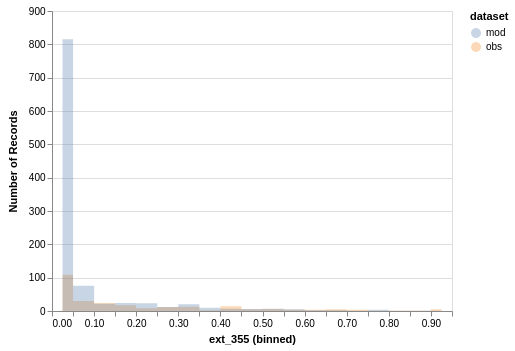

In [10]:
alt.Chart('cast_tall.json').mark_area(opacity=0.3, interpolate='step').encode(
    alt.X('ext_355:Q', bin=alt.Bin(maxbins=20)),
    alt.Y('count()', stack=None),
    color='dataset:N',
).transform_filter(
    (alt.datum.ext_355 <= 1) & (alt.datum.ext_355 > 0)
)



### Orbit/location Plots

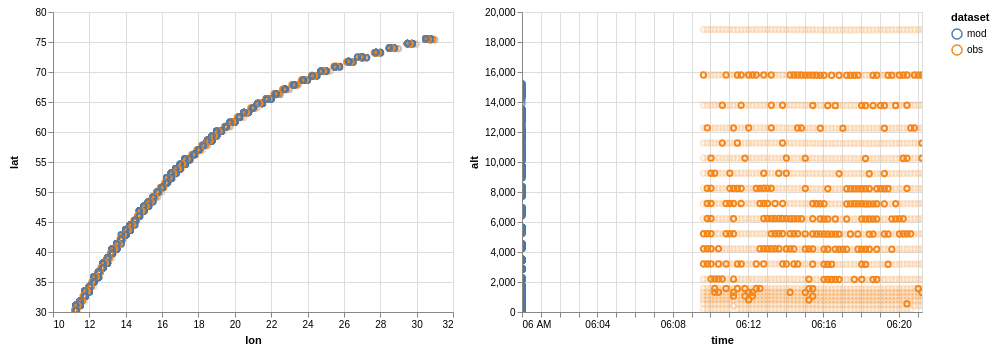

In [11]:
base = alt.Chart('cast_tall.json').encode(
    color='dataset:N',
    opacity=alt.condition((alt.datum.ext_355 <= 2) & (alt.datum.ext_355 > 0),  alt.value(1), alt.value(0.2)),
    tooltip=['point:O', 'time:T', 'lon:Q', 'lat:Q', 'alt:Q', 'ext_355:Q']
)

lonlat = base.mark_point().encode(
    alt.X('lon:Q', scale=alt.Scale(zero=False)),
    alt.Y('lat:Q', scale=alt.Scale(zero=False)),
).interactive()

timealt = base.mark_point().encode(
    x='time:T',
    y='alt:Q',
).interactive()

lonlat | timealt

### Orbit & Scatter Plots

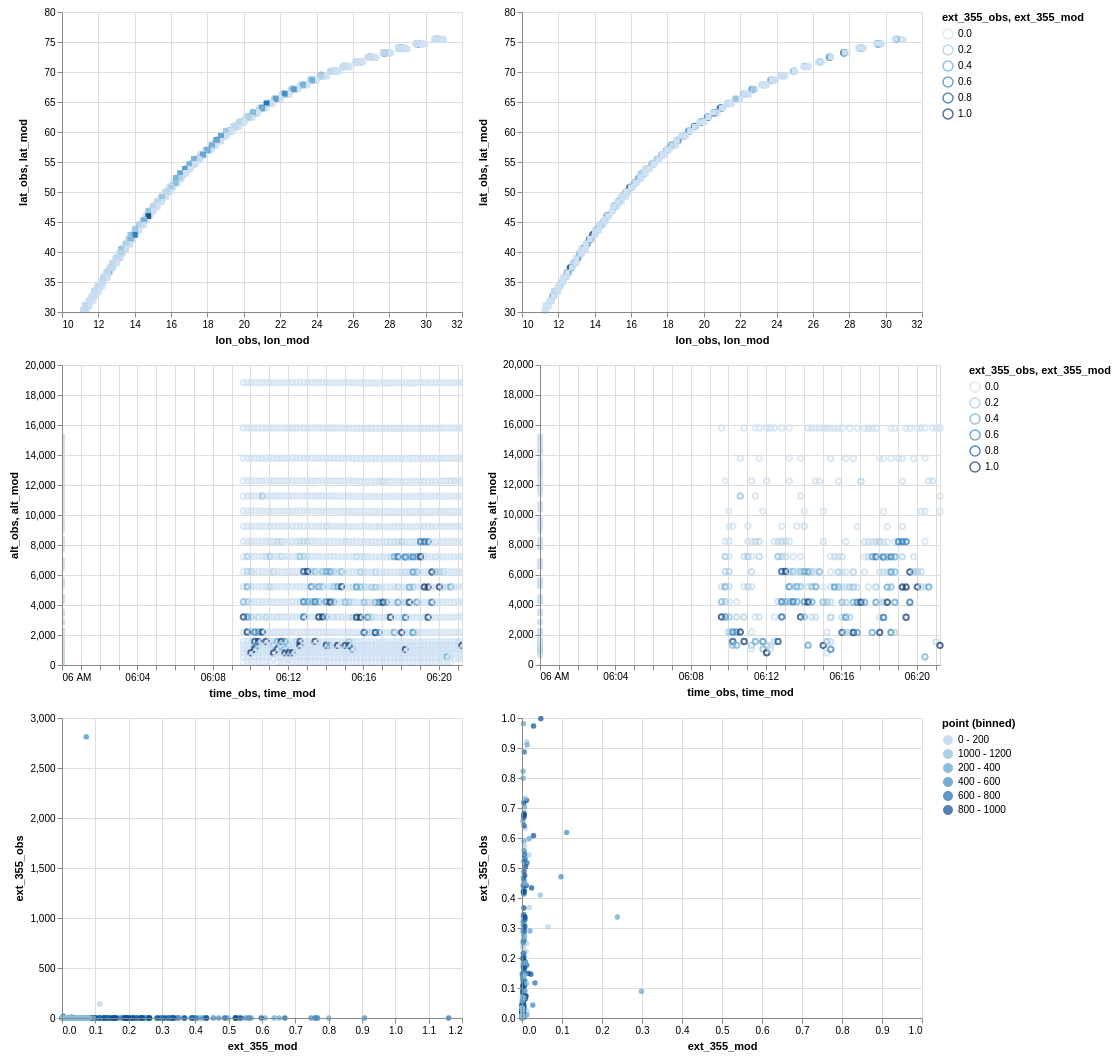

In [15]:
brush = alt.selection(type='interval', resolve='global')

base = alt.Chart('cast_wide.json').encode(
    color=alt.condition(brush, alt.Color('point:O', bin=alt.Bin(maxbins=10)), alt.value('lightgray')),
#   opacity=alt.condition((alt.datum.ext_355_obs <= 1) & (alt.datum.ext_355_obs > 0), alt.value(1), alt.value(0.2)),
)
obs = base.encode(
    color=alt.condition(brush, alt.Color('ext_355_obs:Q', scale=alt.Scale(domain=[0,1])), alt.value('lightgray')),
    tooltip=['point:O', 'time_obs:T', 'lon_obs:Q', 'lat_obs:Q', 'alt_obs:Q', 'ext_355_obs:Q']
)
mod = base.encode(
    color=alt.condition(brush, alt.Color('ext_355_mod:Q', scale=alt.Scale(domain=[0,1])), alt.value('lightgray')),
    tooltip=['point:O', 'time_mod:T', 'lon_mod:Q', 'lat_mod:Q', 'alt_mod:Q', 'ext_355_mod:Q']
)

lonlat_obs = obs.mark_point().encode(
    alt.X('lon_obs:Q', scale=alt.Scale(zero=False)),
    alt.Y('lat_obs:Q', scale=alt.Scale(zero=False)),
)
lonlat_mod = mod.mark_square().encode(
    alt.X('lon_mod:Q', scale=alt.Scale(zero=False)),
    alt.Y('lat_mod:Q', scale=alt.Scale(zero=False)),
)
lonlat = lonlat_obs + lonlat_mod.interactive()
lonlat_clean = lonlat_obs.transform_filter(
    (alt.datum.ext_355_obs <= 1) & (alt.datum.ext_355_obs > 0)
) + lonlat_mod.transform_filter(
    (alt.datum.ext_355_obs <= 1) & (alt.datum.ext_355_obs > 0)
).add_selection(
    brush
)

timealt_obs = obs.mark_point().encode(
    alt.X('time_obs:T'),
    alt.Y('alt_obs:Q', scale=alt.Scale(domain=[0,20e3])),
)
timealt_mod = mod.mark_square().encode(
    alt.X('time_mod:T'),
    alt.Y('alt_mod:Q', scale=alt.Scale(domain=[0,20e3])),
)
timealt = timealt_obs + timealt_mod.interactive()
timealt_clean = timealt_obs.transform_filter(
    (alt.datum.ext_355_obs <= 2) & (alt.datum.ext_355_obs > 0)
).add_selection(
    brush
) + timealt_mod.transform_filter(
    (alt.datum.ext_355_obs <= 2) & (alt.datum.ext_355_obs > 0)
)

scatter = base.mark_circle().encode(
    y='ext_355_obs:Q',
    x='ext_355_mod:Q',
    tooltip=['point:O', 'time_obs:T', 'lat_obs:Q', 'alt_obs:Q', 'ext_355_obs:Q', 'ext_355_mod:Q',]
).add_selection(
    brush
)

scatter_clean = scatter.encode(
    alt.Y('ext_355_obs:Q', scale=alt.Scale(domain=[0,1])),
    alt.X('ext_355_mod:Q', scale=alt.Scale(domain=[0,1])),
).transform_filter(
    (alt.datum.ext_355_obs <= 1) & (alt.datum.ext_355_obs > 0)
)

( lonlat | lonlat_clean ) & (timealt | timealt_clean) & ( scatter | scatter_clean)

### Curtain plots

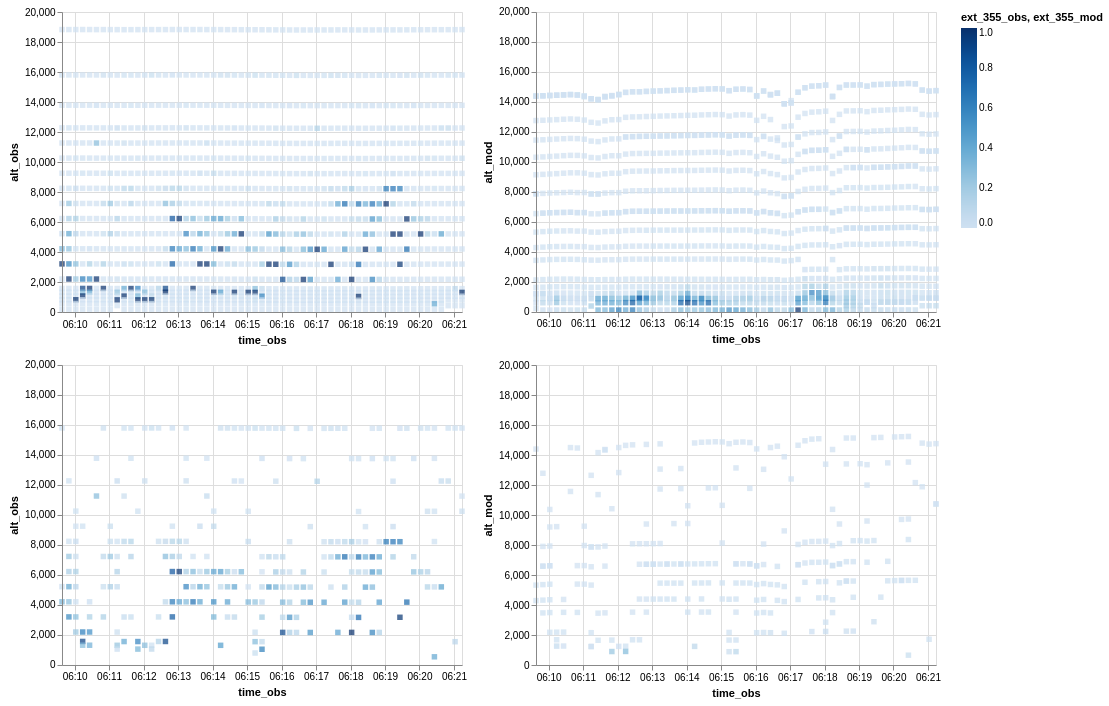

In [14]:
curtain_obs = base.mark_square().encode(
    alt.X('time_obs:T'),
    alt.Y('alt_obs:Q', scale=alt.Scale(domain=[0,20e3])),
    color=alt.condition(brush, alt.Color('ext_355_obs:Q', scale=alt.Scale(domain=[0,1])), alt.value('lightgray')),
    tooltip=['point:O', 'time_obs:T', 'alt_obs:Q', 'ext_355_obs:Q']
).add_selection(
    brush
)

curtain_mod = base.mark_square().encode(
    alt.X('time_obs:T'),
    alt.Y('alt_mod:Q', scale=alt.Scale(domain=[0,20e3])),
    color=alt.condition(brush, alt.Color('ext_355_mod:Q', scale=alt.Scale(domain=[0,1])), alt.value('lightgray')),
    tooltip=['point:O', 'time_mod:T', 'alt_mod:Q', 'ext_355_mod:Q']
).add_selection(
    brush
)

curtain_obs_clean = curtain_obs.transform_filter(
    (alt.datum.ext_355_obs <= 1) & (alt.datum.ext_355_obs > 0)
)

curtain_mod_clean = curtain_mod.transform_filter(
    (alt.datum.ext_355_obs <= 1) & (alt.datum.ext_355_obs > 0)
)

( curtain_obs | curtain_mod ) & ( curtain_obs_clean | curtain_mod_clean )